# Import Libraries

In [98]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Define the backtest symbol and days to predict and days to look back

In [99]:
ticker_symbol = 'ETH-USD'
future_steps = 30
look_back = 1
np.random.seed(7)

# Define the function to preprocess the data    

In [100]:
def new_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0:4] 
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0:4])
    return np.array(dataX), np.array(dataY)

# Build the model   

In [101]:
model = Sequential([
    LSTM(100, input_shape=(look_back, 4), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4) 
])
model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Get the data from Yahoo Finance

In [102]:
ETH_Ticker = yf.Ticker(ticker_symbol)
ETH_Data = ETH_Ticker.history(period="max", interval="1d")


# Preprocess the data

In [103]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = ETH_Data.iloc[:-future_steps, 0:4].values
scaled_data = scaler.fit_transform(dataset)
trainX, trainY = new_dataset(scaled_data, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 4))


# Train the model

In [104]:
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2, callbacks=[early_stopping])


Epoch 1/200
2344/2344 - 21s - loss: 0.0195 - 21s/epoch - 9ms/step
Epoch 2/200
2344/2344 - 11s - loss: 0.0027 - 11s/epoch - 5ms/step
Epoch 3/200
2344/2344 - 14s - loss: 0.0025 - 14s/epoch - 6ms/step
Epoch 4/200
2344/2344 - 14s - loss: 0.0021 - 14s/epoch - 6ms/step
Epoch 5/200
2344/2344 - 14s - loss: 0.0019 - 14s/epoch - 6ms/step
Epoch 6/200
2344/2344 - 14s - loss: 0.0018 - 14s/epoch - 6ms/step
Epoch 7/200
2344/2344 - 15s - loss: 0.0017 - 15s/epoch - 6ms/step
Epoch 8/200
2344/2344 - 14s - loss: 0.0015 - 14s/epoch - 6ms/step
Epoch 9/200
2344/2344 - 14s - loss: 0.0015 - 14s/epoch - 6ms/step
Epoch 10/200
2344/2344 - 11s - loss: 0.0015 - 11s/epoch - 5ms/step
Epoch 11/200
2344/2344 - 11s - loss: 0.0014 - 11s/epoch - 5ms/step
Epoch 12/200
2344/2344 - 14s - loss: 0.0015 - 14s/epoch - 6ms/step
Epoch 13/200
2344/2344 - 15s - loss: 0.0014 - 15s/epoch - 6ms/step
Epoch 14/200
2344/2344 - 15s - loss: 0.0014 - 15s/epoch - 6ms/step
Epoch 15/200
2344/2344 - 14s - loss: 0.0014 - 14s/epoch - 6ms/step
Epoc

# Predict the future price day by day

In [105]:
predictedValues = np.array([])
currentStep = trainX[-1:] 

for i in range(future_steps):
    nextStep = model.predict(currentStep)
    currentStep = np.append(currentStep[:, 1:, :], nextStep.reshape(1, 1, 4), axis=1)
    predictedValues = np.append(predictedValues, nextStep)
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)


1/1 [==============================] - 2s 2s/step
2344/2344 - 12s - loss: 0.0010 - 12s/epoch - 5ms/step
1/1 [==============================] - 0s 76ms/step
2344/2344 - 10s - loss: 9.3655e-04 - 10s/epoch - 4ms/step
1/1 [==============================] - 0s 37ms/step
2344/2344 - 10s - loss: 9.6547e-04 - 10s/epoch - 4ms/step
1/1 [==============================] - 0s 129ms/step
2344/2344 - 10s - loss: 9.4683e-04 - 10s/epoch - 4ms/step
1/1 [==============================] - 0s 31ms/step
2344/2344 - 9s - loss: 9.1079e-04 - 9s/epoch - 4ms/step
1/1 [==============================] - 0s 36ms/step
2344/2344 - 9s - loss: 8.6986e-04 - 9s/epoch - 4ms/step
1/1 [==============================] - 0s 31ms/step
2344/2344 - 9s - loss: 8.9224e-04 - 9s/epoch - 4ms/step
1/1 [==============================] - 0s 33ms/step
2344/2344 - 9s - loss: 9.5195e-04 - 9s/epoch - 4ms/step
1/1 [==============================] - 0s 33ms/step
2344/2344 - 9s - loss: 9.6286e-04 - 9s/epoch - 4ms/step
1/1 [====================

# Evaluate the model

In [106]:
predictedValues = np.array(predictedValues).reshape(-1, 4)
result = scaler.inverse_transform(predictedValues)
result = pd.DataFrame(result, columns=['Open', 'High', 'Low', 'Close'])

In [107]:
actualValues = ETH_Data.iloc[-future_steps:, 0:4]
mse = mean_squared_error(actualValues, result)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 52338.160010488355
Root Mean Squared Error: 228.77534834524536


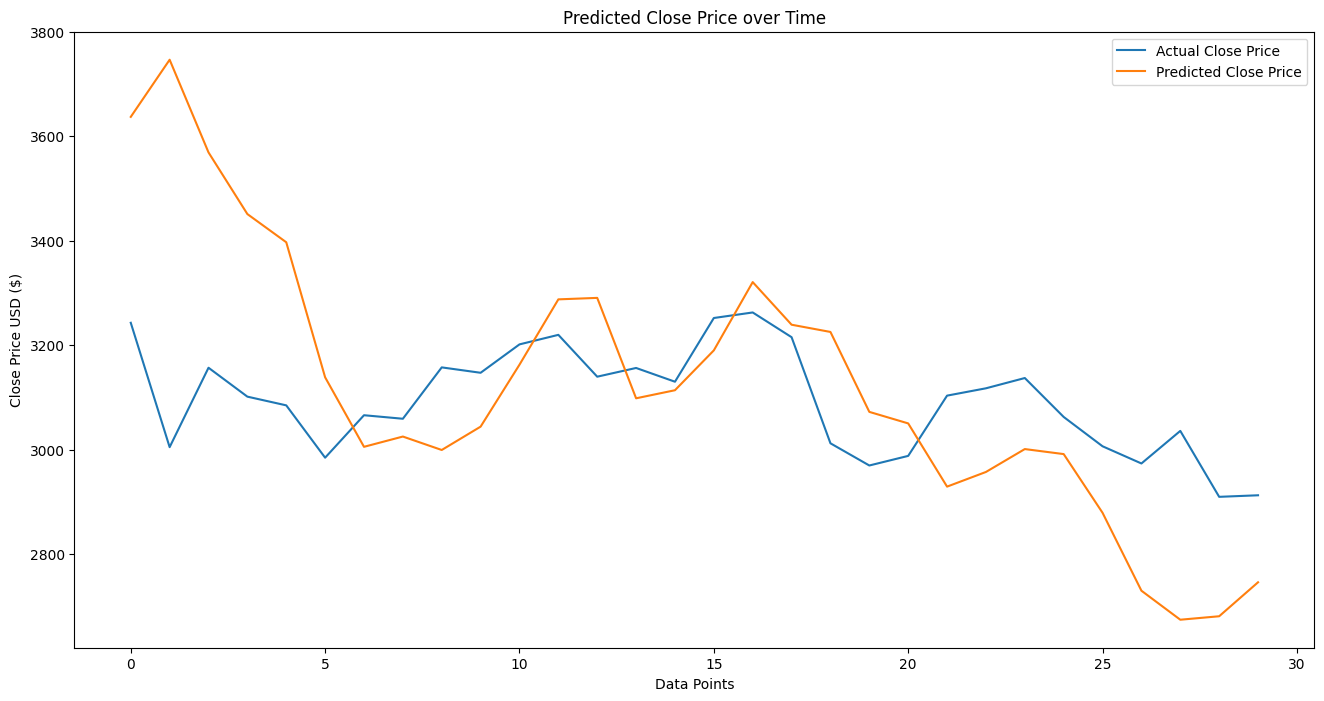

In [108]:
plt.figure(figsize=(16,8))
plt.plot(ETH_Data['Close'][-len(result):].reset_index(drop=True), label='Actual Close Price')
plt.plot(result['Close'], label='Predicted Close Price')

plt.title('Predicted Close Price over Time')
plt.xlabel('Data Points')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()